# Detecting trees on LiDAR data - Local Maxima on Fixed Window Size

## Data


## Procedure
* j


## Evaluation


### LiDAR data CRS info:

### PROJCS["WGS 84 / UTM zone __S21",
    GEOGCS["WGS 84",
        DATUM["WGS_1984",
            SPHEROID["WGS 84",6378137,298.257223563,
                AUTHORITY["EPSG","7030"]],
            AUTHORITY["EPSG","6326"]],
        PRIMEM["Greenwich",0,
            AUTHORITY["EPSG","8901"]],
        UNIT["degree",0.01745329251994328,
            AUTHORITY["EPSG","9122"]],
        AUTHORITY["EPSG","4326"]],
    UNIT["metre",1,
        AUTHORITY["EPSG","9001"]],
    PROJECTION["Transverse_Mercator"],
    PARAMETER["latitude_of_origin",0],
    PARAMETER["central_meridian",-57],  
    PARAMETER["scale_factor",0.9996],
    PARAMETER["false_easting",500000],
    PARAMETER["false_northing",10000000],
    AUTHORITY["EPSG","32721"], 
    AXIS["Easting",EAST],
    AXIS["Northing",NORTH]]

## Packaging Set Up

In [1]:
from google.colab import drive
drive.mount('/content/drive')

#! pip install laspy[lazrs,laszip] &> /dev/null
! pip install geopandas &> /dev/null
! pip install rasterio &> /dev/null
#! pip install Fiona &> /dev/null

#import laspy
#import lazrs
import numpy as np
import pandas as pd
import geopandas as gpd
from osgeo import gdal, osr
from pathlib import Path

import matplotlib.pyplot as plt
import plotly.graph_objects as go

import time
import platform
import warnings
from math import floor

import pyximport

import scipy.ndimage as ndimage
import scipy.ndimage.filters as filters
from skimage.feature import peak_local_max

import fiona
import rasterio

from shapely.geometry import mapping, Point, Polygon

from rasterio.features import shapes as rioshapes

master_path = '/content/drive/MyDrive/Pachama'

Mounted at /content/drive


## Cleaning, Detection and Evaluation Functions

In [98]:
##################### TREE DETECTION FUNCTIONS #####################

def to_lonlat(ul_lon, ul_lat, pix_x, pix_y, resolution):
    ''' 
    Returns latitude and longitude parameters for pixels in a raster
    ''' 

    lon = ul_lon + (pix_x * resolution)
    lat = ul_lat - (pix_y * resolution)
    return lon, lat

def get_kernel(radius=5, circular=False):
    ''' 
    Generates a block or disc-shaped window applied for local maxima filters
    ''' 

    if circular:
        y, x = np.ogrid[-radius:radius+1, -radius:radius+1]
        return x ** 2 + y ** 2 <= radius ** 2
    else:
        return np.ones((int(radius), int(radius)))
    
def filter_chm(chm_file, ws, ws_in_pixels=False, circular=False):
    ''' 
    Pre-process the canopy height model by smoothing with 
    median filter and removing outliers.
    ''' 

    chm_file_path = Path(chm_file)

    try:
        chm = gdal.Open(str(chm_file_path), gdal.GA_ReadOnly)
    except RuntimeError as e:
        raise IOError(e)

    geotransform = chm.GetGeoTransform()
    file_resolution = abs(geotransform[-1])    
    chm = chm.GetRasterBand(1).ReadAsArray()

    if not ws_in_pixels:
        if ws % file_resolution:
            raise Exception("Check if image resolution matches filter size in meters or pixels.")
        else:
            ws = int(ws / file_resolution)

    smooth_chm = ndimage.median_filter(chm,
                                 footprint=get_kernel(ws, circular=circular))

    chm[np.isnan(chm)] = float(0)
    zmask = (smooth_chm < 0.5) | np.isnan(smooth_chm) | (smooth_chm > 60.0)
    smooth_chm[zmask] = 0
    return smooth_chm


def tree_localization(original_chm, smoothened_chm, ws, min_height,
                      resolution=None, ws_in_pixels=False):
    ''' 
    Detect individual trees from CHM raster based on a maximum filter 
    on user determined window size and minimum height
    '''

    original_chm_file_path = Path(original_chm)

    try:
        chm = gdal.Open(str(original_chm_file_path), gdal.GA_ReadOnly)
    except RuntimeError as e:
        raise IOError(e)

    geotransform = chm.GetGeoTransform()
    file_resolution = abs(geotransform[-1])
    ul_lon = chm.GetGeoTransform()[0]
    ul_lat = chm.GetGeoTransform()[3]

    if not isinstance(smoothened_chm, np.ndarray):
        raise Exception("Input raster as numpy ndarray is needed")

    resolution = resolution if resolution else file_resolution

    if not ws_in_pixels:
        if ws % resolution:
            raise Exception("Image filter size not an integer number. "
                            "Please check if image resolution matches "
                            "filter size (in metre or pixel).")
        else:
            ws = int(ws / resolution)
            min_height = int(min_height / resolution)

    # Maximum filter to find local peaks
    raster_maximum = ndimage.maximum_filter(
        smoothened_chm, footprint=get_kernel(ws, circular=True))
    tree_maxima = smoothened_chm == raster_maximum

    # alternative using skimage peak_local_max
    # chm = smoothened_chm.copy()
    # chm[np.isnan(chm)] = 0.
    # tree_maxima = peak_local_max(
    #     chm, indices=False, footprint=get_kernel(ws, circular=True))

    # remove tree tops lower than minimum height
    tree_maxima[smoothened_chm <= min_height] = 0

    # individual tree labeling
    tree_markers, num_objects = ndimage.label(tree_maxima)

    if num_objects == 0:
        raise Exception("NoTreesFound")

    # place the tree top in the center of mass of the pixel bounds
    yx = np.array(
        ndimage.center_of_mass(
            smoothened_chm, tree_markers, range(1, num_objects+1)
        ), dtype=np.float32
    ) + 0.5
    xy = np.array((yx[:, 1], yx[:, 0])).T

    trees = [Point(*to_lonlat(ul_lon=ul_lon, ul_lat=ul_lat,
                              pix_x=xy[tidx, 0], pix_y=xy[tidx, 1],
                              resolution=resolution))
             for tidx in range(len(xy))]

    return pd.DataFrame(
        np.array([trees], dtype='object').T,
        dtype='object', columns=['located_tree_top'])

##################### DATA CLEANING FUNCTIONS #####################

def nan_replacer(df_column):
    ''' 
    Handle NaN values that appear on the Ground Truth csv file
    ''' 
    column = df_column.replace({"NA": np.nan, "NANANANA": np.nan, "NANANANANA": np.nan})
    column = pd.to_numeric(column)
    return column

def extract_coordinates(row):
  '''
  Returns latitude an longitude form a point figure
  '''
  point = row['located_tree_top']
  point_mapped = mapping(point)
  Lon = point_mapped['coordinates'][1]
  Lat = point_mapped['coordinates'][0]
  return (Lat, Lon)

##################### RESULTS EVALUATION FUNCTIONS ##################

def window_results(chm, range_1, range_n):
  ''' 
  Evaluates the number of identified trees over diferent window 
  sizes, with a fixed minimum height
  ''' 

  smooth_chm = filter_chm(chm, ws=5, ws_in_pixels=True, circular=True) 

  window_sizes = [*range(range_1, range_n, 1)]

  window_results = pd.DataFrame(columns=["window_size", "trees_detected"])

  for window in window_sizes:
    
    tree_points = tree_localization(original_chm=chm, smoothened_chm=smooth_chm,
                                    ws=window, min_height=0, ws_in_pixels=True)

    results_row = pd.DataFrame({
        "window_size": [window],
        "trees_detected": [len(tree_points)]
        })
    window_results = pd.concat([window_results, results_row], ignore_index=True)

  return window_results

def results_ploting(geo_df, zone_number, located_trees):
  ''' 
  Plots identified trees by local maxima in red vs
  ground truth trees in green
  ''' 

  points = geo_df['ground_truth_loc']
  polygons = zone8_geo_gt['GT_tree_area']

  fig, ax = plt.subplots(figsize=(10, 10))

  # Create an empty scatter plot for Detected Trees
  detected_scatter = ax.scatter([], [], color='red', label='Detected Trees')

  # Add all the Detected Tree points 
  x, y = zip(*[(p.xy[0][0], p.xy[1][0]) for p in located_trees['located_tree_top']])
  detected_scatter = ax.scatter(x, y, color='red')

  points.plot(ax=ax, color='green', markersize=10, label='Ground Truth Trees')
  #polygons.plot(ax=ax, facecolor='none', edgecolor='black')

  # Set plot title and axis labels
  name = str("Detected Trees Location - Zone " + str(zone_number))
  ax.set_title(name)
  ax.set_xlabel('Lat')
  ax.set_ylabel('Lon')
  ax.legend()
  
  return plt.show()

def tree_results(chm, smooth_ws, detection_ws, min_height, ws_in_pixels=True, circular=True):
    ''' 
    Combines tree identification on one window size and 
    results plotting function
    ''' 

    smooth_chm = filter_chm(chm, ws=smooth_ws,
                            ws_in_pixels=ws_in_pixels,
                            circular=circular)

    tree_points = tree_localization(original_chm=chm, smoothened_chm=smooth_chm,
                                    ws=detection_ws, min_height=min_height, ws_in_pixels=ws_in_pixels)
    
    print("Total detected trees: ", len(tree_points))

    return tree_points

def gen_geoseries(latitude_series, longitude_series, point_series):
  '''
  Returns a GeoPandas Series object with a Multindex generated from
  Latitude and Longitude
  '''
  latitude = latitude_series.round(0).array
  longitude = longitude_series.round(0).array
  arrays= [latitude, longitude]

  index = pd.MultiIndex.from_arrays(arrays, names=('Latitude', 'Longitude'))

  return gpd.GeoSeries(point_series.array,
                       index = index, crs = "EPSG:32721")
  
def eval_geoseries(geoSeries1, geoSeries2):
  '''
  Returns the number of detected trees that are within the generated tree crown 
  for the Ground Truth registered trees. 

  The crown was generated with the GeoPandas function "buffer" and the average
  radius of the trees. While this evaluation is performed by implementing the 
  GeoPandas function "within". 
  
  -- Disclaimer: THIS EVALUATION METHOD IS STILL NOT WORKING GOOD ENOUGH due
  the disparities in registers between Ground Truth data and detected trees
  '''
  trees_within_ground_truth = eval_loc_trees.within(eval_ground_truth, align = True)
  print("Total trees within Ground Truth: ", trees_within_ground_truth.sum())

## Ground Truth Data Handling

In [3]:
### Load Ground Truth Data - Provided by Sustainable Landcapes GeoNetwork Catalog

path = '/content/drive/MyDrive/Pachama/ANA_A01_2015_2018_Inventory_delivery.csv'

ground_truth = pd.read_csv(path, encoding='ISO-8859-1')

### Eliminate identified dead trees from ground truth data
ground_truth = ground_truth[ground_truth['Dead.2018']==False]

ground_truth = ground_truth.iloc[:,-2:].rename(columns={"UTM.Easting": "Latitude",
                                            "UTM.Northing": "Longitude"})

### Clip coordinates to line up LiDAR and Ground Truth boundaries
ground_truth = ground_truth[(ground_truth['Latitude'] >= 721917.4) &
                            (ground_truth['Latitude'] <= 722917.4)]

ground_truth = ground_truth[(ground_truth['Longitude'] >= 9627871) &
                            (ground_truth['Longitude'] <= 9628871)]

ground_truth = ground_truth.reset_index().drop(columns="index")

### Generate Point Geometries with Latitude and Longitude
geo_gt = gpd.GeoDataFrame(ground_truth,
                          geometry = gpd.points_from_xy(ground_truth.Latitude,
                                                        ground_truth.Longitude)).rename_geometry('ground_truth_loc')

### Look for duplicated locations within Ground Truth Data
duplicates_lat = geo_gt['Latitude'].value_counts()
duplicates_lat = duplicates_lat[duplicates_lat > 1]

duplicates_lon = geo_gt['Longitude'].value_counts()
duplicates_lon = duplicates_lon[duplicates_lon > 1]

geo_gt[(geo_gt.Longitude.isin(duplicates_lon.index)) &
       (geo_gt.Latitude.isin(duplicates_lat.index))]

,Latitude,Longitude,ground_truth_loc
115,722334.3090,9628017.347,POINT (722334.309 9628017.347)
116,722334.3090,9628017.347,POINT (722334.309 9628017.347)
245,722344.9588,9628187.441,POINT (722344.959 9628187.441)
247,722344.9588,9628187.441,POINT (722344.959 9628187.441)
268,722344.5155,9628195.466,POINT (722344.515 9628195.466)
272,722344.5155,9628195.466,POINT (722344.515 9628195.466)
470,722606.9920,9628427.016,POINT (722606.992 9628427.016)
472,722606.9920,9628427.016,POINT (722606.992 9628427.016)


In [4]:
### Eliminate Duplicates and order data by Latitude value
duplicates = [115, 245, 268, 470]

geo_gt = (geo_gt.drop(duplicates, axis=0)
          .sort_values(by="Latitude", ascending=True)
          .reset_index(drop=True))

geo_gt.head(5)

,Latitude,Longitude,ground_truth_loc
0,722061.5738,9628849.016,POINT (722061.574 9628849.016)
1,722061.8670,9628860.517,POINT (722061.867 9628860.517)
2,722062.1127,9628870.153,POINT (722062.113 9628870.153)
3,722067.6661,9628846.908,POINT (722067.666 9628846.908)
4,722067.8569,9628856.758,POINT (722067.857 9628856.758)


In [5]:
# Check for remaining duplicates
duplicates_lat = geo_gt['Latitude'].value_counts()
duplicates_lat = duplicates_lat[duplicates_lat > 1]

duplicates_lon = geo_gt['Longitude'].value_counts()
duplicates_lon = duplicates_lon[duplicates_lon > 1]

print("Duplicates Latitude: ", duplicates_lat.values.sum())
print("Duplicates Longitude: ", duplicates_lon.values.sum())

Duplicates Latitude:  2
Duplicates Longitude:  6


In [ ]:
# Obtain mean radius from Ground Truth Data to plot the "synthethic tree crowns"

path = str(master_path + "/ANA_A01_2015_2018_Inventory_delivery.csv")
radius_truth = pd.read_csv(path, encoding='ISO-8859-1')

north_mean = nan_replacer(radius_truth['RN.2015']).mean(skipna = True)
south_mean = nan_replacer(radius_truth['RS.2015']).mean(skipna = True)
east_mean = nan_replacer(radius_truth['RE.2015']).mean(skipna = True)
west_mean = nan_replacer(radius_truth['RW.2015']).mean(skipna = True)

total_mean = (east_mean + north_mean + south_mean + west_mean)/4

## Plot the mean radius distirbution

fig = go.Figure()

fig.add_trace(go.Histogram(x=nan_replacer(radius_truth['RN.2015']),
                           name='North', marker_color = '#48bb78'))
fig.add_trace(go.Histogram(x=nan_replacer(radius_truth['RS.2015']),
                           name='South',  marker_color = '#222222'))
fig.add_trace(go.Histogram(x=nan_replacer(radius_truth['RE.2015']),
                           name='East', marker_color = '#4DBC5D'))
fig.add_trace(go.Histogram(x=nan_replacer(radius_truth['RW.2015']),
                           name='West', marker_color = '#1B2326'))

fig.update_layout(title_text='Radius distibutions', barmode='overlay')


fig.update_traces(opacity=0.5)
fig.show()

The radius size distribution shows a skew to the right - which may need to be considered at the time of generating the synthetic ground truth tree crowns.

In [10]:
### Generate Synthethic Tree Crowns - Fixed to average crown width: 
geo_gt['GT_tree_area'] = geo_gt.ground_truth_loc.buffer(distance = round(total_mean, 2))
geo_gt

,Latitude,Longitude,ground_truth_loc,GT_tree_area
0,722061.5738,9628849.016,POINT (722061.574 9628849.016),"POLYGON ((722068.044 9628849.016, 722068.013 9..."
1,722061.8670,9628860.517,POINT (722061.867 9628860.517),"POLYGON ((722068.337 9628860.517, 722068.306 9..."
2,722062.1127,9628870.153,POINT (722062.113 9628870.153),"POLYGON ((722068.583 9628870.153, 722068.552 9..."
3,722067.6661,9628846.908,POINT (722067.666 9628846.908),"POLYGON ((722074.136 9628846.908, 722074.105 9..."
4,722067.8569,9628856.758,POINT (722067.857 9628856.758),"POLYGON ((722074.327 9628856.758, 722074.296 9..."
...,...,...,...,...
971,722916.5372,9628708.379,POINT (722916.537 9628708.379),"POLYGON ((722923.007 9628708.379, 722922.976 9..."
972,722916.5463,9628740.703,POINT (722916.546 9628740.703),"POLYGON ((722923.016 9628740.703, 722922.985 9..."
973,722916.5627,9628734.931,POINT (722916.563 9628734.931),"POLYGON ((722923.033 9628734.931, 722923.002 9..."
974,722916.6037,9628720.503,POINT (722916.604 9628720.503),"POLYGON ((722923.074 9628720.503, 722923.043 9..."


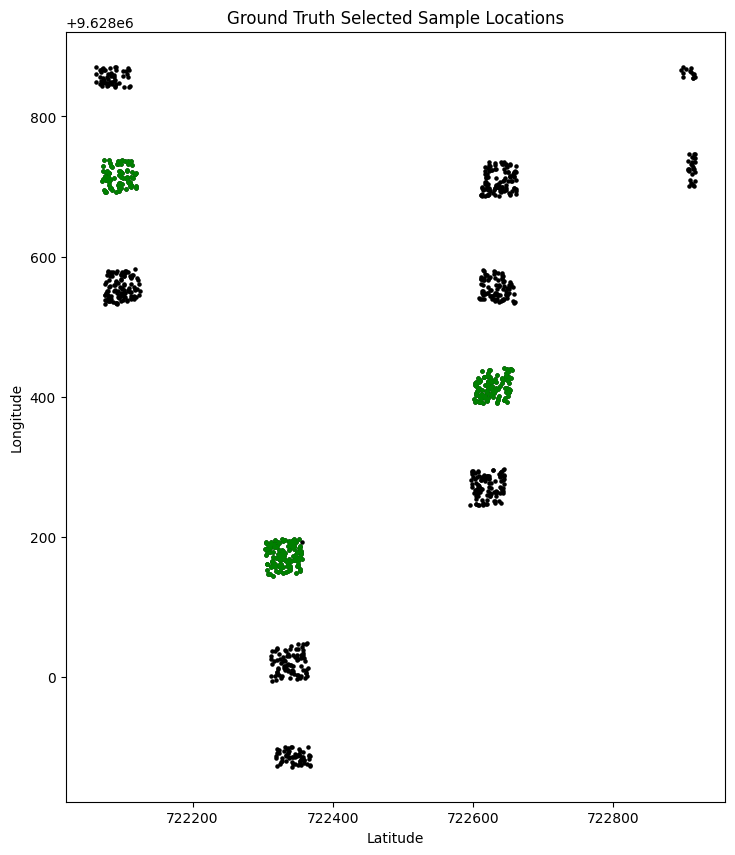

In [16]:
# Clip data to ground truth selected sample zones (8,18 and 22)
path = str(master_path + "/Inventory_geometries/inventory_geometry_0.shp")
geom_zone8 = gpd.read_file(path)
zone8_geo_gt = geo_gt.clip(geom_zone8)

path = str(master_path + "/Inventory_geometries/inventory_geometry_1.shp")
geom_zone18 = gpd.read_file(path)
zone18_geo_gt = geo_gt.clip(geom_zone18)

path = str(master_path + "/Inventory_geometries/inventory_geometry_2.shp")
geom_zone22 = gpd.read_file(path)
zone22_geo_gt = geo_gt.clip(geom_zone22)


# Read in the polygon and point data
# polygons = geo_gt['GT_tree_area']
points = geo_gt['ground_truth_loc']

zone8_points = zone8_geo_gt['ground_truth_loc']
zone18_points = zone18_geo_gt['ground_truth_loc']
zone22_points = zone22_geo_gt['ground_truth_loc']

# Create a new plot
fig, ax = plt.subplots(figsize=(10, 10))

# Plot the polygons and points on the same axis
# polygons.plot(ax=ax, facecolor='none', edgecolor='black')
points.plot(ax=ax, color='black', markersize=5)
zone8_points.plot(ax=ax, color='green', markersize=5)
zone18_points.plot(ax=ax, color='green', markersize=5)
zone22_points.plot(ax=ax, color='green', markersize=5)

# Set the plot title and axis labels
ax.set_title('Ground Truth Selected Sample Locations')
ax.set_xlabel('Latitude')
ax.set_ylabel('Longitude')

# Show the plot
plt.show()

## Tree identification with Local Maxima - Fixed Window Size

### Test over Zone 8

In [94]:
CHM_zone8 = str(master_path + '/CHMs/CHM_8.tif')

print("Total number of trees in Ground Truth data: ", len(zone8_geo_gt))

# test window sizes for # of identified trees
window_results(chm = CHM_zone8, range_1 = 1, range_n = 15)

Total number of trees in Ground Truth data:  130


,window_size,trees_detected
0,1,172
1,2,54
2,3,32
3,4,27
4,5,25
5,6,19
6,7,19
7,8,15
8,9,13
9,10,13


Total detected trees:  130


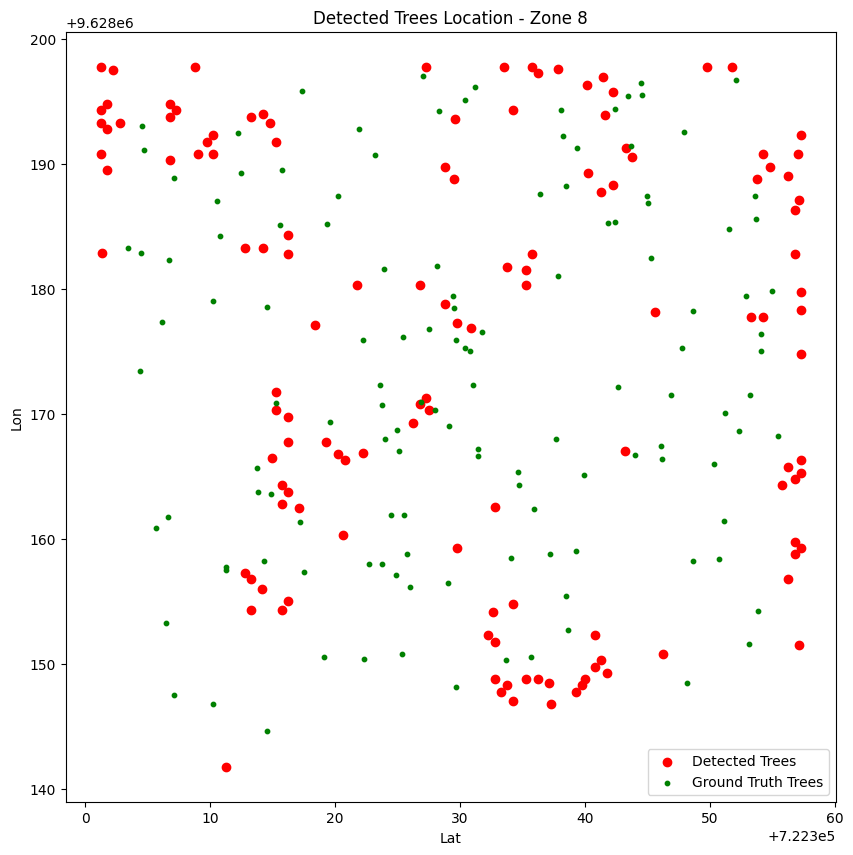

In [112]:
located_trees = tree_results(chm = CHM_zone8, smooth_ws = 8, detection_ws = 1,
                             min_height = 0, ws_in_pixels=True, circular=True)

results_ploting(zone8_geo_gt, 8, located_trees)

The Window Size that permits to get closer to the number of Ground Truth Trees is **1** with a minimum height of 0. The **Local Maxima method overestimates tree count by 42 trees (+32.3%)**

In [108]:
# Extract Latitude and Longitude from coordinates in points
located_trees[['Latitude', 'Longitude']] = located_trees.apply(extract_coordinates, axis=1, result_type='expand')

# Generate GeoPandas Series with Multi-index to evaluate results
eval_loc_trees = gen_geoseries(located_trees['Latitude'],
                               located_trees['Longitude'],
                               located_trees['located_tree_top'])

eval_ground_truth = gen_geoseries(zone8_geo_gt['Latitude'],
                                  zone8_geo_gt['Longitude'],
                                  zone8_geo_gt['GT_tree_area'])

# Evaluate detected trees within Ground Truth trees:
eval_geoseries(eval_loc_trees, eval_ground_truth)

Total trees within Ground Truth:  5


/usr/local/lib/python3.9/dist-packages/geopandas/base.py:31: UserWarning: The indices of the two GeoSeries are different.
  warn("The indices of the two GeoSeries are different.")


### Test over Zone 18:

In [100]:
CHM_zone18 = str(master_path + '/CHMs/CHM_18.tif')

print("Total number of trees in Ground Truth data: ", len(zone18_geo_gt))

# test window sizes for # of identified trees
window_results(chm = CHM_zone18, range_1 = 1, range_n = 15)

Total number of trees in Ground Truth data:  110


,window_size,trees_detected
0,1,168
1,2,57
2,3,29
3,4,27
4,5,22
5,6,21
6,7,19
7,8,19
8,9,16
9,10,15


Total detected trees:  99


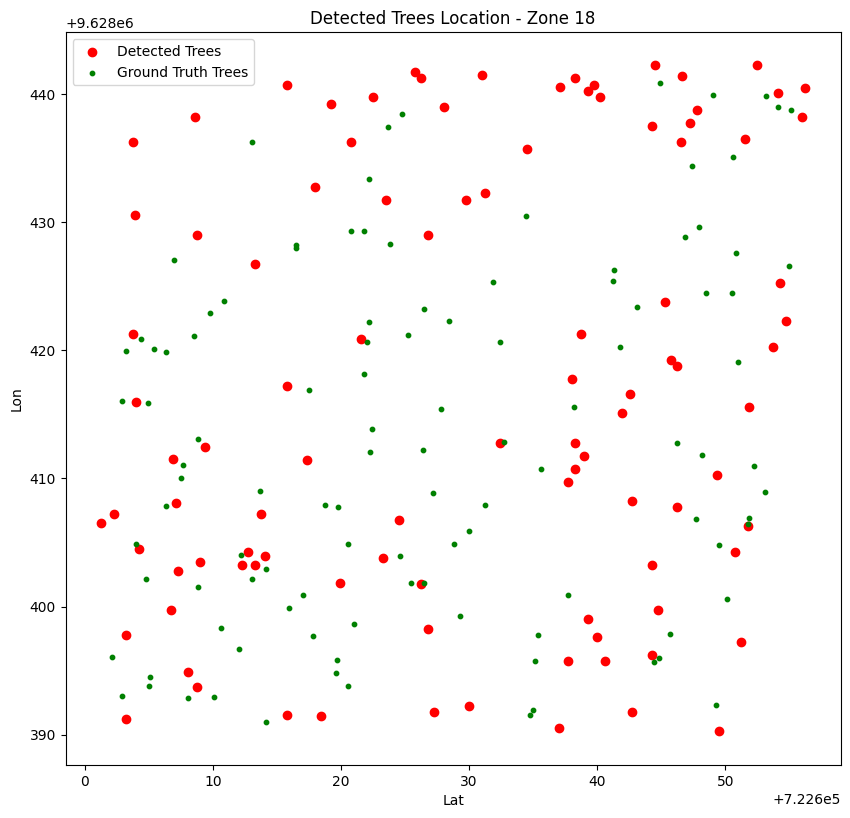

In [140]:
located_trees = tree_results(chm = CHM_zone18, smooth_ws = 2, detection_ws = 2,
                             min_height = 0, ws_in_pixels=True, circular=True)

results_ploting(zone18_geo_gt, 18, located_trees)

The Window Size that permits to get closer to the number of Ground Truth Trees is **2** with a minimum height of 0 and a smoothening window size of 2. The **Local Maxima method underestimates tree count by 11 trees (-10%)**

In [113]:
# Extract Latitude and Longitude from coordinates in points
located_trees[['Latitude', 'Longitude']] = located_trees.apply(extract_coordinates, axis=1, result_type='expand')

# Generate GeoPandas Series with Multi-index to evaluate results
eval_loc_trees = gen_geoseries(located_trees['Latitude'],
                               located_trees['Longitude'],
                               located_trees['located_tree_top'])

eval_ground_truth = gen_geoseries(zone8_geo_gt['Latitude'],
                                  zone8_geo_gt['Longitude'],
                                  zone8_geo_gt['GT_tree_area'])

# Evaluate detected trees within Ground Truth trees:
eval_geoseries(eval_loc_trees, eval_ground_truth)

Total trees within Ground Truth:  5


/usr/local/lib/python3.9/dist-packages/geopandas/base.py:31: UserWarning: The indices of the two GeoSeries are different.
  warn("The indices of the two GeoSeries are different.")


### Test over Zone 22:

In [114]:
CHM_zone22 = str(master_path + '/CHMs/CHM_22.tif')

print("Total number of trees in Ground Truth data: ", len(zone22_geo_gt))

# test window sizes for # of identified trees
window_results(chm = CHM_zone22, range_1 = 1, range_n = 15)

Total number of trees in Ground Truth data:  84


,window_size,trees_detected
0,1,130
1,2,38
2,3,20
3,4,16
4,5,15
5,6,14
6,7,12
7,8,9
8,9,9
9,10,7


Total detected trees:  98


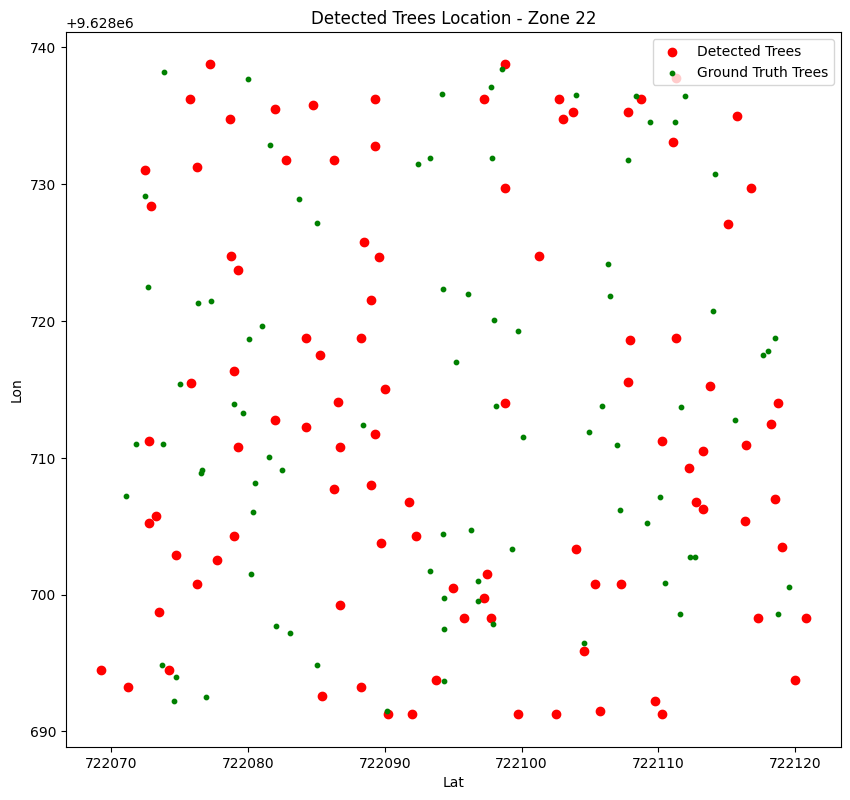

In [137]:
located_trees = tree_results(chm = CHM_zone22, smooth_ws = 2, detection_ws = 2, 
                             min_height = 0, ws_in_pixels=True, circular=True)

results_ploting(zone22_geo_gt, 22, located_trees)

The Window Size that permits to get closer to the number of Ground Truth Trees is **2** with a minimum height of 0 and a smoothening window size of 2. The **Local Maxima method overestimates tree count by 11 trees (+16.67%)**

## Out of curiosity: Applying DBSCAN

In [ ]:
#Read LAS file
inFile = laspy.read("/content/drive/MyDrive/Pachama/LiDAR_Data/ANA_A01_2018_LAS_6.laz")
inFile = laspy.convert(inFile)

#Import LAS into numpy array (X=raw integer value x=scaled float value)
lidar_points = np.array((inFile.x,inFile.y,inFile.z)).transpose()#inFile.intensity, inFile.raw_classification,inFile.scan_angle_rank

#Transform to pandas DataFrame
lidar_df=DataFrame(lidar_points)

#Transform to geopandas GeoDataFrame
crs = None
geometry = [Point(xyz) for xyz in zip(inFile.x,inFile.y,inFile.z)]
lidar_geodf = GeoDataFrame(lidar_df, crs=crs, geometry=geometry)
lidar_geodf.crs = {'init' :'epsg:32721'} # set correct spatial reference